In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
# Load the dataset
df = pd.read_csv('utkFace1_int.csv')
df

,age,ethnicity,gender,img_name,pixels
0,35,1,0,20170116025838482.jpg.chip.jpg,'217 168 111 37 22 23 37 48 82 91 91 91 91 91 ...
1,18,0,1,20170109212647587.jpg.chip.jpg,'109 114 131 84 79 60 62 66 83 162 167 163 163...
2,44,1,0,20170113142045653.jpg.chip.jpg,'238 240 219 183 171 157 147 142 137 126 119 1...
3,21,2,1,20170109213056053.jpg.chip.jpg,'215 217 219 216 213 52 51 40 42 44 47 47 37 2...
4,29,1,1,20170117193933170.jpg.chip.jpg,'4 6 13 12 10 11 16 25 18 8 9 10 15 15 25 60 8...
...,...,...,...,...,...
366,35,3,0,20170104214739069.jpg.chip.jpg,'243 246 248 248 243 106 28 89 129 159 172 186...
367,22,1,0,20170113133555880.jpg.chip.jpg,'162 167 38 38 40 64 133 152 167 169 172 180 1...
368,34,1,1,20170113001409411.jpg.chip.jpg,'40 54 49 36 46 51 55 42 34 51 63 44 53 66 85 ...
369,53,0,1,20170109012814840.jpg.chip.jpg,'70 84 105 117 120 105 102 107 122 134 147 163...


In [ ]:
# Convert pixels to numeric type
X = []
for pixels in df['pixels']:
    try:
        pixels_float = [float(pixel) for pixel in pixels]
        X.append(pixels_float)
    except ValueError:
        X.append(np.nan)
X = np.array(X)

In [ ]:
# Convert the target labels to integers
y = y.astype(int)


In [ ]:
# Resize images to (48, 48)
X_resized = []
for image in X:
    resized_image = cv2.resize(image, (48, 48))
    X_resized.append(resized_image)

# Convert the resized images to an array
X = np.array(X_resized)

# Reshape X to match the expected shape of the VGG16 model (48x48 grayscale)
X = X.reshape(-1, 48, 48, 1)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert labels to categorical format
y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)

# Resize images to (224, 224) and convert to RGB format
X_resized_train = []
X_resized_valid = []

In [ ]:
for image in X_train:
    image_uint8 = (image * 255).astype(np.uint8)
    resized_image = cv2.resize(image_uint8, (224, 224))
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    X_resized_train.append(rgb_image)

for image in X_valid:
    image_uint8 = (image * 255).astype(np.uint8)
    resized_image = cv2.resize(image_uint8, (224, 224))
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    X_resized_valid.append(rgb_image)

In [ ]:
# Convert the resized images to arrays
X_train_resized = np.array(X_resized_train)
X_valid_resized = np.array(X_resized_valid)

# Load pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_resized, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_valid_resized, y_valid_categorical))

Epoch 1/10
10/10 [==============================] - 683s 67s/step - loss: 1.9851 - accuracy: 0.3818 - val_loss: 1.5189 - val_accuracy: 0.3867
Epoch 2/10
10/10 [==============================] - 722s 72s/step - loss: 1.4600 - accuracy: 0.4054 - val_loss: 1.5611 - val_accuracy: 0.3867
Epoch 3/10
10/10 [==============================] - 704s 71s/step - loss: 1.4477 - accuracy: 0.4054 - val_loss: 1.5328 - val_accuracy: 0.3867
Epoch 4/10
10/10 [==============================] - 671s 67s/step - loss: 1.4330 - accuracy: 0.4054 - val_loss: 1.5175 - val_accuracy: 0.3867
Epoch 5/10
10/10 [==============================] - 664s 66s/step - loss: 1.4372 - accuracy: 0.4054 - val_loss: 1.5316 - val_accuracy: 0.3867
Epoch 6/10
10/10 [==============================] - 699s 70s/step - loss: 1.4297 - accuracy: 0.4054 - val_loss: 1.5469 - val_accuracy: 0.3867
Epoch 7/10
10/10 [==============================] - 655s 66s/step - loss: 1.4419 - accuracy: 0.4054 - val_loss: 1.5284 - val_accuracy: 0.3867
Epoch 

In [ ]:
# Evaluate the model on the validation set
y_valid_pred_proba = model.predict(X_valid_resized)
y_valid_pred = np.argmax(y_valid_pred_proba, axis=1)

3/3 [==============================] - 41s 11s/step


In [ ]:
accuracy = accuracy_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid_categorical, y_valid_pred_proba, multi_class='ovr')


In [ ]:
print("Validation Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)

Validation Accuracy: 0.38666666666666666
ROC AUC Score: 0.5056943361541155


True Positive Rate (TPR): {0: array([0.        , 0.06896552, 1.        ]), 1: array([0.        , 0.06666667, 1.        ]), 2: array([0., 1.]), 3: array([0.        , 0.90909091, 1.        ]), 4: array([0., 1., 1.])}
False Positive Rate (FPR): {0: array([0.        , 0.04347826, 1.        ]), 1: array([0.  , 0.05, 1.  ]), 2: array([0., 1.]), 3: array([0.      , 0.953125, 1.      ]), 4: array([0.        , 0.94117647, 1.        ])}


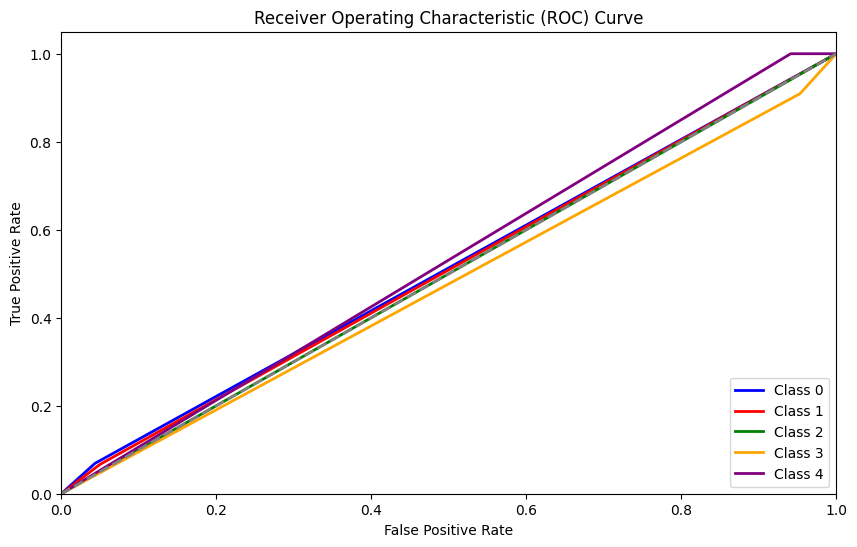

In [ ]:
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_categorical[:, i], y_valid_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_valid_categorical[:, i], y_valid_pred_proba[:, i])

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Extract TP, FP, TN, FN
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Calculate TPR and FPR
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [ ]:
precision[i] = precision_score(y_valid, y_valid_pred, average=None, zero_division=1)[i]
recall[i] = recall_score(y_valid, y_valid_pred, average=None, zero_division=1)[i]
f_measure[i] = f1_score(y_valid, y_valid_pred, average=None, zero_division=1)[i]


In [ ]:
# Calculate accuracy on validation set
y_valid_pred = np.argmax(y_valid_pred_proba, axis=1)
accuracy = accuracy_score(y_valid, y_valid_pred)

# Calculate precision, recall, and F-measure for each class
precision = dict()
recall = dict()
f_measure = dict()
for i in range(5):
    precision[i] = precision_score(y_valid, y_valid_pred, average=None)[i]
    recall[i] = recall_score(y_valid, y_valid_pred, average=None)[i]
    f_measure[i] = f1_score(y_valid, y_valid_pred, average=None)[i]

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  ROC AUC: {roc_auc[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F-Measure: {f_measure[i]}")


Accuracy: 0.38666666666666666
Class 0:
  ROC AUC: 0.512743628185907
  Precision: 0.38666666666666666
  Recall: 1.0
  F-Measure: 0.5576923076923077
Class 1:
  ROC AUC: 0.5083333333333333
  Precision: 0.0
  Recall: 0.0
  F-Measure: 0.0
Class 2:
  ROC AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  F-Measure: 0.0
Class 3:
  ROC AUC: 0.47798295454545453
  Precision: 0.0
  Recall: 0.0
  F-Measure: 0.0
Class 4:
  ROC AUC: 0.5294117647058824
  Precision: 0.0
  Recall: 0.0
  F-Measure: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

# Create table
table = [["TPR", tpr],
         ["FPR", fpr],
         ["Precision", precision],
         ["Recall", recall],
         ["F-Measure", f_measure]]

# Print table
print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid"))

+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Metric    | Value                                                                                                                                                                                        |
+===========+==============================================================================================================================================================================================+
| TPR       | {0: array([0.        , 0.06896552, 1.        ]), 1: array([0.        , 0.06666667, 1.        ]), 2: array([0., 1.]), 3: array([0.        , 0.90909091, 1.        ]), 4: array([0., 1., 1.])} |
+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------